<a href="https://colab.research.google.com/github/Dhanyabahadur/project_notebooks/blob/main/Topic_Modeling_with_Quantized_LLMs_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modeling with Quantized LLMs**
*Create easily interpretable topics with BERTopic and LLMs*
<br>

<img src="https://pbs.twimg.com/media/GDA2JQoX0AElWoq?format=jpg&name=large">


---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We'll investigate the utilization of Llama for Topic Modeling, eliminating the necessity to input each document individually into the model. Instead, we'll employ BERTopic, a modular topic modeling approach capable of fine-tuning topic representations with any LLM. BERTopic follows a simple process, involving five sequential steps: document embedding, dimensionality reduction of embeddings, clustering of embeddings, tokenization of documents within clusters, and ultimately extracting the most representative words for each topic.



Yet, with the emergence of advanced language models like **Llama**, we can surpass the conventional approach of obtaining disparate words for each topic. Directly analyzing all documents using Llama is computationally impractical. While vector databases can be employed for search, the challenge lies in determining which topics to search for. Instead, we will capitalize on the clusters and topics generated by BERTopic, allowing Llama to refine and distill this information into a more precise representation. This approach seamlessly combines the topic creation capability of BERTopic with the refined topic representation offered by Llama, providing an optimal solution.

We will start by installing a number of packages that we are going to use throughout this example:

In [ ]:
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

# Install sklearn for loading data
!pip install scikit-learn

This code snippet imports necessary libraries for data manipulation and machine learning, sets up configurations, and initializes random seed values for reproducibility. Here's a breakdown of the main components:

1. **Import Libraries:** Import essential libraries such as NumPy, Pandas, tqdm, warnings, gc, scipy, scikit-learn, and torch for data processing, modeling, and evaluation.

2. **Configure Display Options:** Set Pandas display options to show longer column width.

3. **Download NLTK Resources:** Download stopwords from NLTK (Natural Language Toolkit).

4. **Define Seed Function:** `seed_all` function is defined to set random seed values for Python, CPU, and GPU variables to ensure reproducibility.

5. **Set Random Seeds:** The `seed_all(2)` call initializes random seed values with the chosen seed value '2'. This step is crucial for reproducibility in machine learning experiments.

Overall, this code snippet is a setup block commonly used in machine learning projects to establish a reproducible environment by fixing random seed values.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
from ast import literal_eval
import re
import random
from sklearn.preprocessing import LabelEncoder
import torch
pd.options.display.max_colwidth = 200
import re, spacy
import nltk
nltk.download('stopwords')



def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 📄 **Data**

We are going to apply topic modeling on a number of Research Papers. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

I got the data from [kaggle](https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles/data?select=train.csv)

This code snippet performs the following tasks:

1. **Read Data:** Loads the dataset from a CSV file located at "/content/train.csv" in a Colab environment.

2. **Text Processing:** Combines the "TITLE" and "ABSTRACT" columns into a new "text" column. It then defines a `pre_process` function to clean the text data.

   - Removes newline characters and unwanted symbols.
   - Eliminates digits and special characters.
   - Converts uppercase to lowercase.
   - Removes unnecessary white spaces.
   - Removes stop words using the spaCy library.

3. **Apply Pre-processing:** Applies the `pre_process` function to the "text" column of the DataFrame.

4. **Final Output:** Assigns the pre-processed text to the variable `cleaned_text_list`.

Overall, this code snippet loads a dataset, combines relevant text columns, and performs pre-processing steps to clean and prepare the text data for further analysis or modeling.

In [ ]:
# path where data is stored in colab - "/content/train.csv"
train = pd.read_csv('/content/train.csv')
train.ABSTRACT = train.ABSTRACT.str.replace("\n"," ")
train["text"] = train["TITLE"] + train["ABSTRACT"]


def pre_process(df):
  df['text'] = df['text'].str.replace('\n', '')
  df['text'] = df['text'].str.replace('\r', '')
  df['text'] = df['text'].str.replace('\t', '')

  # This removes unwanted texts
  df['text'] = df['text'].apply(lambda x: re.sub(r'[0-9]','',x))
  df['text'] = df['text'].apply(lambda x: re.sub(r'[/(){}\[\]\|@,;.:-]',' ',x))

  #Converting all upper case to lower case
  df['text']= df['text'].apply(lambda s:s.lower() if type(s) == str else s)

  #Remove un-necessary white space
  df['text']=df['text'].str.replace('  ',' ')

  #Remove Stop words
  nlp=spacy.load("en_core_web_sm")
  df['text'] =df['text'].apply(lambda x: ' '.join([word for word in x.split() if nlp.vocab[word].is_stop==False ]))
  return df

cleaned_text_list = pre_process(train)
cleaned_text_list = cleaned_text_list.text

A sample of data.

In [ ]:
cleaned_text_list[23]

'complexity deciding detectability discrete event systems detectability discrete event systems dess question current subsequent states determined based observations shu lin designed polynomial time algorithm check strong periodic detectability exponential time polynomial space algorithm check weak periodic detectability zhang showed checking weak periodic detectability pspace complete intractable complexity opens question structurally simpler dess problem tractable paper case considering dess represented deterministic finite automata non trivial cycles structurally simplest deadlock free dess simple dess checking weak periodic detectability remains intractable contrary strong periodic detectability dess efficiently verified parallel computer'

Length of longest string.

In [ ]:
max1 = 0
for cleaned_text in cleaned_text_list:
  if(len(cleaned_text)>max1):
    max1 = len(cleaned_text)
print(max1)

1924


# 🦙 **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

In [ ]:
!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

--2024-01-15 08:17:35--  https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.239.50.103, 18.239.50.16, 18.239.50.49, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.103|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/65/3b/653b1cc7a4558cd22c0ac02df471105878a080cb5694622ccd566697c574592f/cd58120326971c71c0590f6b7084a0744e287ce9c67275d8b4bf34a5947d950b?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27openhermes-2.5-mistral-7b.Q4_K_M.gguf%3B+filename%3D%22openhermes-2.5-mistral-7b.Q4_K_M.gguf%22%3B&Expires=1705565856&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTU2NTg1Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzY1LzNiLzY1M2IxY2M3YTQ1NThjZDIyYzBhYzAyZGY0NzExMDU4NzhhMDgwY2I1Njk0NjIyY2NkNTY2Njk3YzU3NDU5M

Next, we load the model using `llama-cpp-python`:

In [ ]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=max1, stop=["Q:", "\n"])

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [ ]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# 🗨️ **BERTopic**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(cleaned_text_list, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/656 [00:00<?, ?it/s]

In [ ]:
# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=400, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(cleaned_text_list, embeddings)

2024-01-15 08:20:25,250 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-15 08:20:25,702 - BERTopic - Dimensionality - Completed ✓
2024-01-15 08:20:25,704 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-15 08:20:26,934 - BERTopic - Cluster - Completed ✓
2024-01-15 08:20:26,961 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 5/5 [00:47<00:00,  9.47s/it]
2024-01-15 08:21:19,732 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,8818,-1_model_data_based_time,"[model, data, based, time, paper, problem, results, learning, network, system]","[adversarial, models, model, algorithms, dynamics, networks, stochastic, optimization, learning, algorithm]","[""Data-driven Model Learning Systems"", , , , , , , , , ]",[uncertainty reduction stochastic processes complex networks real world systems characterized stochastic dynamical rules complex network interactions individual elements probabilistically determin...
1,0,5698,0_data_learning_model_based,"[data, learning, model, based, networks, network, method, algorithm, paper, models]","[algorithms, optimization, networks, prediction, algorithm, regression, datasets, sparse, models, model]","['Data Learning Methods Networks', , , , , , , , , ]",[weighted community detection data clustering message passing grouping objects clusters based similarities weights important problems science engineering work extending message passing algorithms ...
2,1,3089,1_mathbb_group_prove_mathcal,"[mathbb, group, prove, mathcal, finite, groups, spaces, space, paper, functions]","[algebraic, algebras, polynomials, elliptic, manifolds, equations, symmetric, conjecture, mathbb, polynomial]","[Algebraic Geometry and Complex Analysis., , , , , , , , , ]",[homotopy lie algebra symplectomorphism groups fold blow ups $ s^ \times s^ σ_ std \oplus σ_ std $ consider point blow manifold $ s^ \times s^ \sigma \oplus \sigma $ $\sigma$ standard symplectic f...
3,2,2135,2_spin_quantum_magnetic_phase,"[spin, quantum, magnetic, phase, field, temperature, energy, states, state, transition]","[graphene, superconducting, phonon, quantum, fermi, magnetic, phases, phase, symmetry, lattice]","[Quantum Phase Transition & Magnetic Fields, , , , , , , , , ]",[nature magnetic phase transition weyl semimetal investigate nature magnetic phase transition induced short ranged electron electron interactions weyl semimetal perturbative renormalization group ...
4,3,1232,3_mass_star_stars_galaxies,"[mass, star, stars, galaxies, observations, stellar, galaxy, data, dark, emission]","[galaxies, galactic, accretion, galaxy, redshift, planets, cosmological, cosmic, stellar, flux]","[Galaxy Stellar Masses and Observations, , , , , , , , , ]",[vales molecular gas content star forming dusty h atlas galaxies z= present extragalactic survey observations atacama large millimeter submillimeter array alma characterise galaxy populations $z= ...


# 📊 Visualization with DataMapPlot

In [ ]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

We can use the labels created by the LLM and assign them to topics that we have created:

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

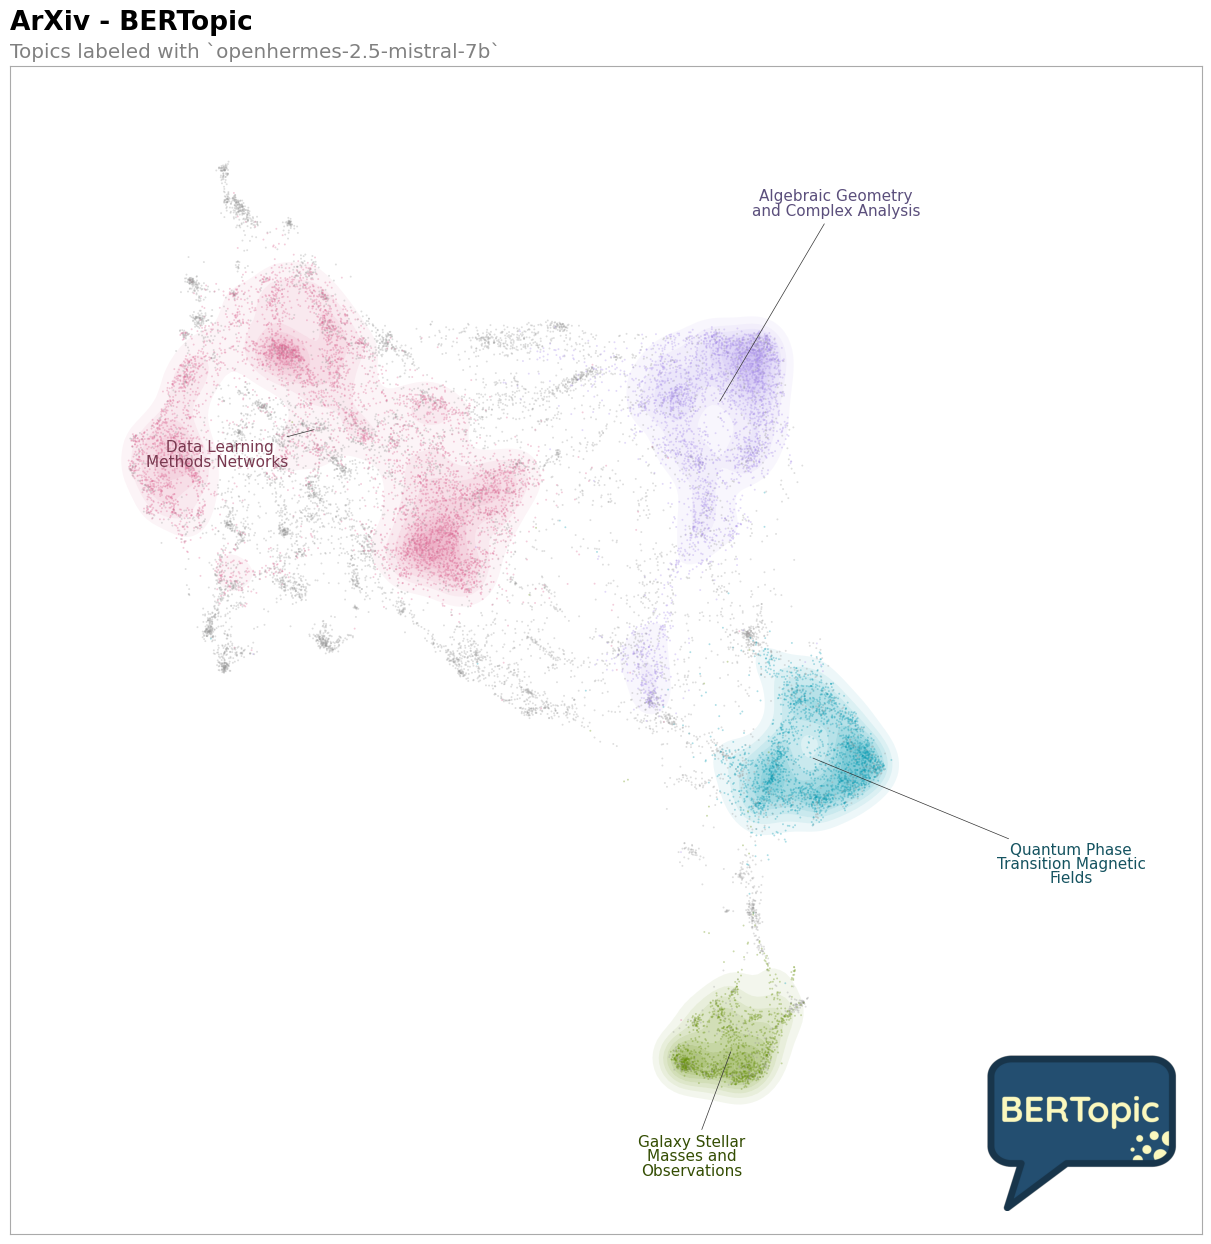

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="ArXiv - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    logo=bertopic_logo,
    logo_width=0.16
)